In [1]:
# Import libraries 
from tqdm import tqdm

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor

import matplotlib.pyplot as plt

#### 1. Prepare functions for model setup and training

In [2]:
def split_train_val_and_test_set(X, Y, train_ratio, validation_ratio, test_ratio):
    """ Split datasets into training, validation, and test sets."""
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [3]:
class Dataset(torch.utils.data.Dataset):
  """ Characterizes a dataset for PyTorch."""
    
  def __init__(self, X, Y):
      """ Initialize the datasets."""
      self.X = X
      self.Y = Y
      
  def __len__(self):
      """ Return the number of training examples."""
      return self.X.shape[0]

  def __getitem__(self, index):
      """ Generate one sample of the training data."""
      x = self.X[index, :]
      y = self.Y[index, :]
      return x, y

In [4]:
class Autoencoder(nn.Module):
    """ 
    Implementation of a basic Autoencoder.
    """
    
    def __init__(self, input_size):
        super().__init__()
        self._input_size = input_size

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        
        encoded = self.encoder(x)    
        decoded = self.decoder(encoded)
        
        return decoded

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """ Perform a training loop."""
    running_loss = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        # Send the batch samples to a device
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        decoded = model(X)
        loss = loss_fn(decoded, X)
        running_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        # Update model weights
        optimizer.step()
        # Re-set gradients to zero for next batch
        optimizer.zero_grad()

    avg_training_loss = running_loss / len(dataloader)
    
    return avg_training_loss

In [6]:
def validation_loop(dataloader, model, loss_fn):
    """ Perform a validation loop."""
    running_loss = 0
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            # Send the batch samples to a device
            X, y = X.to(device), y.to(device)
            
            # Compute prediction and loss
            decoded = model(X)
            loss = loss_fn(decoded, X)
            running_loss += loss.item()

    avg_validation_loss = running_loss / len(dataloader)

    return avg_validation_loss

In [7]:
def train_model(training_generator, validation_generator, model, loss_fn, optimizer, epochs):
    
    # Collect results
    training_loss = []
    validation_loss = []
    
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

        # Perform a training step
        running_training_loss = train_loop(
            dataloader=training_generator, 
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        training_loss.append(running_training_loss)

        # Perform a validation step
        running_validation_loss = validation_loop(
            dataloader=validation_generator,
            model=model,
            loss_fn=loss_fn
        )
        validation_loss.append(running_validation_loss)

    return training_loss, validation_loss

In [8]:
def plot_loss(training_loss, validation_loss, model_id):
    """ Plot training and validation losses."""
    fig = plt.figure(figsize=[5, 3])
    ax = fig.add_subplot(111)
    ax.plot(training_loss, label="Training loss")
    ax.plot(validation_loss, label="Validation loss")
    ax.set_title("Model: {}".format(model_id))
    ax.legend()

In [9]:
def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in test_loader:
            X  = X.to(device)
            output = model(X)
            test_loss += F.mse_loss(output, X, reduction='sum').item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average MSE loss: {:.4f}\n'.format(test_loss))

In [10]:
# Define training tools
loss_functions = {
    "binary_cross_entropy": nn.BCELoss,
    "cross_entropy": nn.CrossEntropyLoss,
    "mse_loss": nn.MSELoss,
}
optimizers = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
}
# Search for a device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

#### 2. Configuration

In [11]:
# Define parameters configuration
# https://github.com/victoresque/pytorch-template/blob/master/README.md
params = {
    "data_splitting" : {
        "train_ratio": 0.8,
        "validation_ratio": 0.1,
        "test_ratio": 0.1,
    },
    
    "dataloader": {
        "batch_size": 32,
        "shuffle": True,
        "num_workers" : 0
    },
    
    "loss": {
        "type": "mse_loss",
        "params" : {
            "reduction": "mean"
        }
    },

    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.0001,
            "betas": (0.9, 0.999), 
            "eps": 1e-08,
            "weight_decay": 1e-8,
            # "momentum": 0,
            # "weight_decay": 0.001,
        }
    },

    "training": {
        "epochs" : 15
    },
}  

#### 3. Prepare training, validation, and test sets

In [12]:
# Load the training data
mnist_train = datasets.MNIST(
    root="datasets",
    train=True,
    download=True,
    transform=Compose([
        ToTensor(),
        torch.flatten,
    ]))

# Load the test data
mnist_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        torch.flatten,
    ]))

In [13]:
# # Visualize the results
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
#     img, label = mnist_train[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(label)
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()

In [14]:
# Generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=0.1,
)

In [15]:
# Generate a subset based on indices
training_dataset = Subset(mnist_train, train_indices)
validation_dataset = Subset(mnist_train, val_indices)

In [16]:
# Create generators
training_generator = DataLoader(training_dataset, **params["dataloader"])
validation_generator = DataLoader(validation_dataset, **params["dataloader"])
test_generator = DataLoader(mnist_test, **params["dataloader"])

#### 4. Initialize the model

In [17]:
# Instantiate a model
autoencoder = Autoencoder(input_size=28*28)
# Transfer the model to device
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
# Number of epochs
epochs = params["training"]["epochs"]
# Define a binary cross entropy loss
loss_fn = loss_functions[params["loss"]["type"]](**params["loss"]["params"])
# Define a stochastic gradient descent as an optimizer
optimizer = optimizers[params["optimizer"]["type"]](autoencoder.parameters(), **params["optimizer"]["params"])

#### 5. Train the model and check performance

In [19]:
# Train and evaluate the model
training_loss, validation_loss = train_model(
    training_generator=training_generator, 
    validation_generator=validation_generator, 
    model=autoencoder, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    epochs=epochs
)

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [01:19<00:00,  5.30s/it]


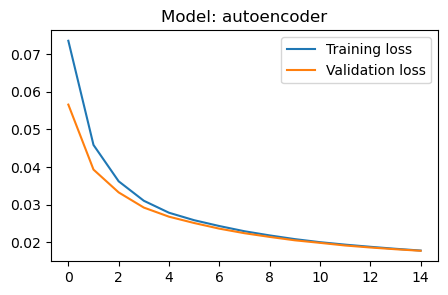

In [20]:
plot_loss(training_loss, validation_loss, "autoencoder")

In [21]:
test_model(model=autoencoder, device=device, test_loader=test_generator)


Test set: Average MSE loss: 13.4806



In [25]:
def decode(model, X):
    """ Get an example of a decoded image."""
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
            
        # Compute prediction and loss
        decoded = model(X)

    return decoded

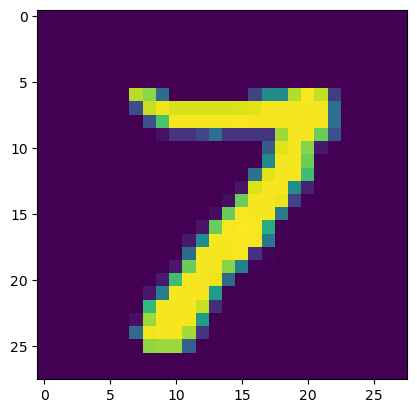

In [26]:
plt.imshow(test_generator.dataset.data[34])

In [27]:
img_example = test_generator.dataset.data[34]
img_example = test_generator.dataset.transform(img_example.numpy())

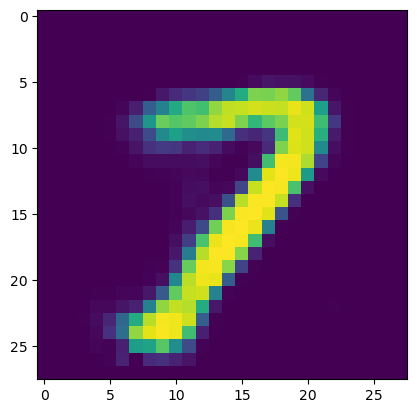

In [28]:
decoded_img = decode(
    model=autoencoder, 
    X=img_example.reshape(-1, 28 * 28).to(device).type(torch.float),
)
plt.imshow(decoded_img.reshape(28, 28).cpu())